Abstract:
This project was designed to investigate the DVOA performance stat utilized to quantify performance in the NFL and see if there is a link between the season DVOA averages for a team vs. their scores in weekly matchups. In addition, I added additional metrics such as how many days of rest each team is on along with indoor vs. outdoor venue and game service to create a ridge regression model with the goal of predicting scores.

This first section is generating my initialiat dataset utilitizing the nfl_data_py library

In [29]:
#Section 1
import pandas as pd
import nfl_data_py as nfl

# Define the season
SEASON = 2024 #Define season 

# Load the schedule data for the 2024 season
# This will include results for completed games.
try:
    schedule_df = nfl.import_schedules([SEASON]) #Import schedule data for the 2024 season
    
    # Select and rename columns to match your request
    
    games_df = schedule_df[[ #generate games dataframe
        'game_id', 'season', 'week', 'away_team', 'home_team', 
        'away_score', 'home_score','gameday','roof','surface'
    ]].copy()

    # Creating game column for greater readability
    games_df['game_id'] = games_df['game_id'].astype(str) # Convert game_id to string for consistency
    games_df['game'] = games_df['away_team'] + ' @ ' + games_df['home_team'] # Create a game column for better readability

    print("Successfully loaded 2024 game and score data.")
    print(games_df.head()) # Display the first few rows of the games DataFrame

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure the 2024 season data is available in the library.")

Successfully loaded 2024 game and score data.
              game_id  season  week away_team home_team  away_score  \
6706   2024_01_BAL_KC    2024     1       BAL        KC        20.0   
6707   2024_01_GB_PHI    2024     1        GB       PHI        29.0   
6708  2024_01_PIT_ATL    2024     1       PIT       ATL        18.0   
6709  2024_01_ARI_BUF    2024     1       ARI       BUF        28.0   
6710  2024_01_TEN_CHI    2024     1       TEN       CHI        17.0   

      home_score     gameday      roof    surface       game  
6706        27.0  2024-09-05  outdoors      grass   BAL @ KC  
6707        34.0  2024-09-06  outdoors        NaN   GB @ PHI  
6708        10.0  2024-09-08    closed  fieldturf  PIT @ ATL  
6709        34.0  2024-09-08  outdoors     a_turf  ARI @ BUF  
6710        24.0  2024-09-08  outdoors      grass  TEN @ CHI  


In [30]:
#Section 2
if not games_df.empty:
    #Create a DataFrame with DVOA data
    dvoa_data = { # Create a dictionary with DVOA data
        'TEAM': ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN',
                 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LV', 'MIA',
                 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB',
                 'TEN', 'WAS'],
        'TOT DVOA': ['8.8%', '-7.3%', '41.4%', '22.7%', '-32.9%', '-12.7%', '7.0%', '-39.9%',
                     '-11.6%', '16.3%', '34.8%', '24.5%', '5.3%', '-7.1%', '-17.7%', '14.7%',
                     '12.6%', '5.1%', '-19.6%', '-9.8%', '16.1%', '-29.7%', '-10.6%',
                     '-21.9%', '-11.4%', '21.3%', '6.3%', '2.3%', '6.7%', '9.4%', '33.5%',
                     '11.5%']
    }

    dvoa_df = pd.DataFrame(dvoa_data) # Convert the dictionary to a DataFrame

   
    # The DVOA ratings are in percentage format, so we need to convert them to a numeric format
    # Remove the '%' sign and convert to float
    dvoa_df['dvoa_rating'] = dvoa_df['TOT DVOA'].str.replace('%', '').astype(float) / 100  # Convert the percentage string to a numeric value

    # We only need the team and the numeric rating for the merge
    dvoa_to_merge = dvoa_df[['TEAM', 'dvoa_rating']] # Select only the relevant columns for merging
    print("DVOA data has been loaded and cleaned.")


    # Merge the DataFrames

    # Merge #1: Add the DVOA rating for the HOME team
    final_df = pd.merge( # Merge the games DataFrame with the DVOA DataFrame
        left=games_df,
        right=dvoa_to_merge,
        left_on='home_team', # Key from the left DataFrame
        right_on='TEAM',      # Key from the right DataFrame
        how='left'
    )
    # Rename the new column and drop the redundant 'TEAM' column
    final_df = final_df.rename(columns={'dvoa_rating': 'home_dvoa'})
    final_df = final_df.drop(columns=['TEAM'])

    # Merge #2: Add the DVOA rating for the AWAY team
    final_df = pd.merge(
        left=final_df,
        right=dvoa_to_merge,
        left_on='away_team', # Key from the left DataFrame
        right_on='TEAM',      # Key from the right DataFrame
        how='left'
    )
    # Rename the new column and drop the redundant 'TEAM' column
    final_df = final_df.rename(columns={'dvoa_rating': 'away_dvoa'})
    final_df = final_df.drop(columns=['TEAM'])

    print("Merging complete.")


    # View the Final Result
    
    # Let's add a DVOA differential column for fun, which is a common metric
    # A positive number means the home team has a better season DVOA rating.
    final_df['dvoa_diff'] = final_df['home_dvoa'] - final_df['away_dvoa']
    
    # Display the first few rows with the new DVOA columns
    print("\n--- Final Merged DataFrame ---")
    print(final_df[['week', 'home_team', 'home_dvoa', 'away_team', 'away_dvoa', 'dvoa_diff']].head())
    #save the final DataFrame to a CSV file
    
final_df.to_csv('data/nfl_2024_games_with_dvoa.csv', index=False)


DVOA data has been loaded and cleaned.
Merging complete.

--- Final Merged DataFrame ---
   week home_team  home_dvoa away_team  away_dvoa  dvoa_diff
0     1        KC      0.147       BAL      0.414     -0.267
1     1       PHI      0.213        GB      0.245     -0.032
2     1       ATL     -0.073       PIT      0.063     -0.136
3     1       BUF      0.227       ARI      0.088      0.139
4     1       CHI     -0.127       TEN      0.335     -0.462


In [31]:
#Section 3
import pandas as pd
#Load dataframe from CSV file
final_df = pd.read_csv('data/nfl_2024_games_with_dvoa.csv')
# Display the first few rows of the final DataFrame
print("\Loaded Final DataFrame from CSV")
print(final_df.head())
# Print column names to verify
print("Column Names:")
print(final_df.columns.tolist())
#Print DataFrame info
print("DataFrame Info:")
print(final_df.info())
#Print DataFrame description
print("DataFrame Description:")
print(final_df.describe())
#print data types of each column
print("Data Types of Each Column:")
print(final_df.dtypes)


\Loaded Final DataFrame from CSV
           game_id  season  week away_team home_team  away_score  home_score  \
0   2024_01_BAL_KC    2024     1       BAL        KC        20.0        27.0   
1   2024_01_GB_PHI    2024     1        GB       PHI        29.0        34.0   
2  2024_01_PIT_ATL    2024     1       PIT       ATL        18.0        10.0   
3  2024_01_ARI_BUF    2024     1       ARI       BUF        28.0        34.0   
4  2024_01_TEN_CHI    2024     1       TEN       CHI        17.0        24.0   

      gameday      roof    surface       game  home_dvoa  away_dvoa  dvoa_diff  
0  2024-09-05  outdoors      grass   BAL @ KC      0.147      0.414     -0.267  
1  2024-09-06  outdoors        NaN   GB @ PHI      0.213      0.245     -0.032  
2  2024-09-08    closed  fieldturf  PIT @ ATL     -0.073      0.063     -0.136  
3  2024-09-08  outdoors     a_turf  ARI @ BUF      0.227      0.088      0.139  
4  2024-09-08  outdoors      grass  TEN @ CHI     -0.127      0.335     -0.462  


<>:6: SyntaxWarning: invalid escape sequence '\L'
<>:6: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipykernel_2993/4145889806.py:6: SyntaxWarning: invalid escape sequence '\L'
  print("\Loaded Final DataFrame from CSV")


In this section I am adding a column to the dataset that contain the number of days of rest each team is on for a given matchup

In [32]:
#Section 4: Days of rest for each team going into each game
if not games_df.empty:
    # Ensure gameday is datetime
    final_df["gameday"] = pd.to_datetime(final_df["gameday"], errors="coerce") 

    # Build long-form appearances (one row per team appearance per game)
    appearances = pd.concat([
        final_df[["game_id", "gameday", "home_team"]].rename(columns={"home_team": "team"}), 
        final_df[["game_id", "gameday", "away_team"]].rename(columns={"away_team": "team"}),
    ], ignore_index=True)

    # Sort by team then date; compute previous game date per team
    appearances = appearances.sort_values(["team", "gameday"])
    appearances["prev_gameday"] = appearances.groupby("team")["gameday"].shift(1)

    # Rest days = days between this game and last game for that team
    appearances["rest_days"] = (appearances["gameday"] - appearances["prev_gameday"]).dt.days

    # Keep only what we need for merging back
    rest_map = appearances[["game_id", "team", "rest_days"]]

    # Merge home rest
    final_df = final_df.merge(
        rest_map.rename(columns={"team": "home_team", "rest_days": "home_rest_days"}),
        on=["game_id", "home_team"],
        how="left"
    )

    # Merge away rest
    final_df = final_df.merge(
        rest_map.rename(columns={"team": "away_team", "rest_days": "away_rest_days"}),
        on=["game_id", "away_team"],
        how="left"
    )

    # Int type with NA support (keeps NaN for a team's first game)
    final_df["home_rest_days"] = final_df["home_rest_days"].astype("Int64")
    final_df["away_rest_days"] = final_df["away_rest_days"].astype("Int64")

    print("\n--- Sample with rest days ---")
    print(final_df[["week","game","gameday","home_rest_days","away_rest_days"]].head())

    # (Re)save with rest columns included
    out_path = "data/nfl_2024_games_with_dvoa.csv"
    final_df.to_csv(out_path, index=False)
    print(f"\nUpdated file saved with rest days: {out_path}")
    #print datatypes of each column
    print("Data Types of Each Column After Adding Rest Days:")
    print(final_df.dtypes)
    


--- Sample with rest days ---
   week       game    gameday  home_rest_days  away_rest_days
0     1   BAL @ KC 2024-09-05            <NA>            <NA>
1     1   GB @ PHI 2024-09-06            <NA>            <NA>
2     1  PIT @ ATL 2024-09-08            <NA>            <NA>
3     1  ARI @ BUF 2024-09-08            <NA>            <NA>
4     1  TEN @ CHI 2024-09-08            <NA>            <NA>

Updated file saved with rest days: data/nfl_2024_games_with_dvoa.csv
Data Types of Each Column After Adding Rest Days:
game_id                   object
season                     int64
week                       int64
away_team                 object
home_team                 object
away_score               float64
home_score               float64
gameday           datetime64[ns]
roof                      object
surface                   object
game                      object
home_dvoa                float64
away_dvoa                float64
dvoa_diff                float64
home_rest_days 

This section answers my first question which is what is the relationship between DVOA and Score. 

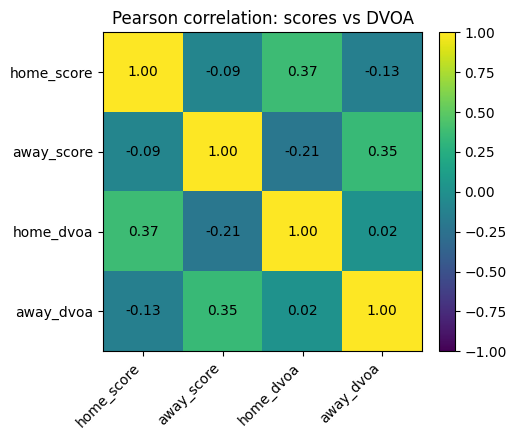

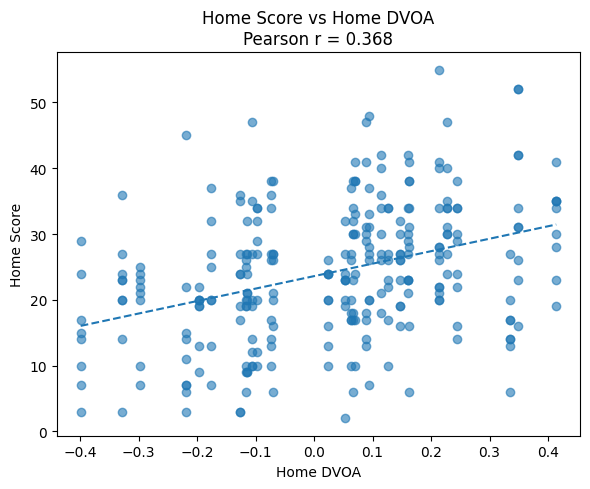

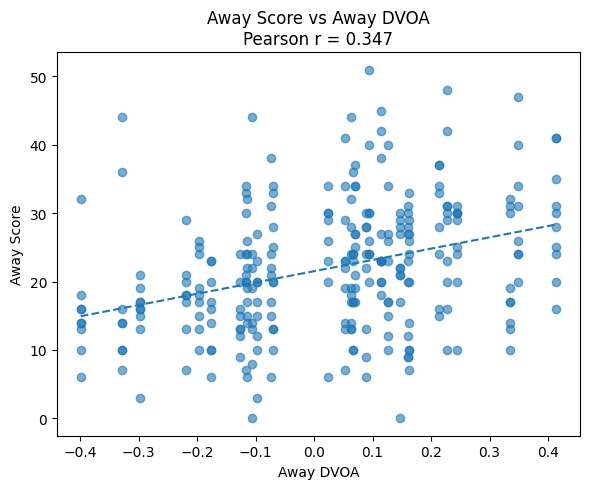

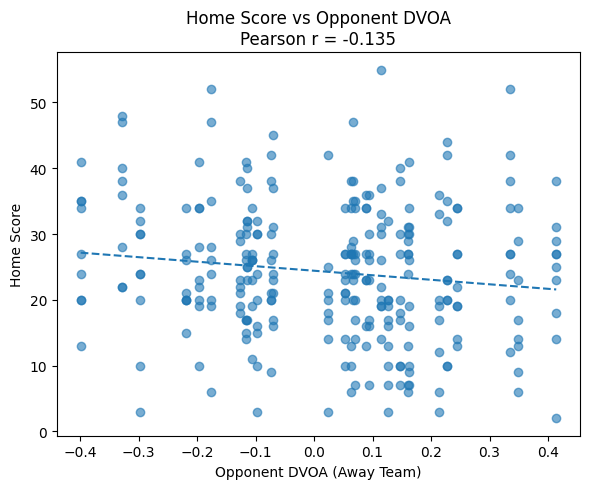

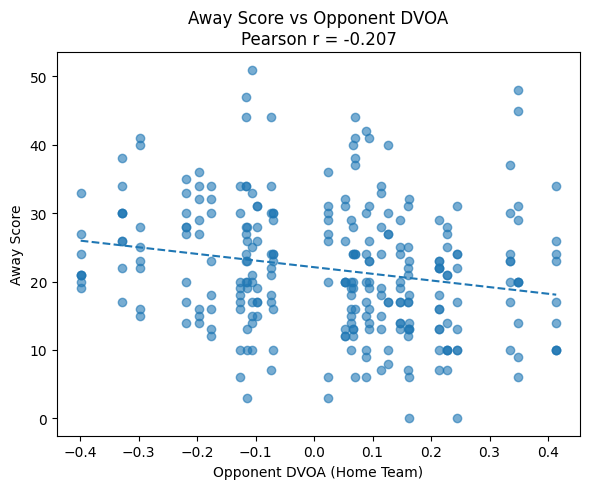

In [33]:
#Section 5: Correlation checks (scores vs DVOA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Correlation heatmap (Pearson)
cols = ["home_score", "away_score", "home_dvoa", "away_dvoa"] # Select relevant columns for correlation
corr = final_df[cols].corr(method="pearson", min_periods=1) # Compute the Pearson correlation matrix

plt.figure(figsize=(5.5, 4.5)) # Create a figure with specified size
im = plt.imshow(corr, vmin=-1, vmax=1) # Display the correlation matrix as an image
plt.colorbar(im, fraction=0.046, pad=0.04) # Add a colorbar to the heatmap
plt.xticks(range(len(cols)), cols, rotation=45, ha="right") # Set x-tick labels and rotation
plt.yticks(range(len(cols)), cols) # Set y-tick labels
for i in range(len(cols)): # Loop through each row
    for j in range(len(cols)): # Loop through each column
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center") # Add text annotations for each cell in the heatmap
plt.title("Pearson correlation: scores vs DVOA")
plt.tight_layout()
plt.savefig('images/corr_heatmap.png')
plt.show()



# 2) Predicted relationship visuals: scatter + simple linear fit
def scatter_with_fit(x, y, xlab, ylab, title): #function that creates a scatterplot with a linear fit line
    x = np.asarray(x, dtype=float) # Convert x to a numpy array of floats
    y = np.asarray(y, dtype=float) # Convert y to a numpy array of floats
    mask = ~(np.isnan(x) | np.isnan(y)) # Create a mask to filter out NaN values
    x, y = x[mask], y[mask]

    r = np.corrcoef(x, y)[0, 1] if x.size > 1 else np.nan

    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, alpha=0.6) # Create a scatter plot with some transparency
    if x.size >= 2: 
        m, b = np.polyfit(x, y, deg=1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m * xs + b, linestyle="--")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(f"{title}\nPearson r = {r:.3f}") # Add title with Pearson correlation coefficient
    plt.tight_layout()
    plt.savefig(f'images/{title.replace(" ", "_").lower()}.png') # Save the plot as an image
    plt.show()

# Same-side relationships
scatter_with_fit(
    final_df["home_dvoa"], final_df["home_score"],
    "Home DVOA", "Home Score", "Home Score vs Home DVOA"
)

scatter_with_fit(
    final_df["away_dvoa"], final_df["away_score"],
    "Away DVOA", "Away Score", "Away Score vs Away DVOA"
)

# Optional: Opponent strength relationships (often insightful)
# Home score vs Opponent (Away) DVOA
scatter_with_fit(
    final_df["away_dvoa"], final_df["home_score"],
    "Opponent DVOA (Away Team)", "Home Score", "Home Score vs Opponent DVOA"
)

# Away score vs Opponent (Home) DVOA
scatter_with_fit(
    final_df["home_dvoa"], final_df["away_score"],
    "Opponent DVOA (Home Team)", "Away Score", "Away Score vs Opponent DVOA"
)

Creating a binary column for if the game is played in or outdoors

In [34]:
#Section 6: Roof column binary conversion
# Normalize text
final_df["roof"] = final_df["roof"].astype(str).str.strip().str.lower()

# Map to binary
roof_to_bin = { 
    "outdoors": 1, "outdoor": 1, "open": 1,          # outdoors
    "dome": 0, "closed": 0, "indoor": 0, "indoors": 0, "closed dome": 0,  # indoor/closed
     "retractable": 0, "retractable roof": 0,      #treating retractable as indoor
}

final_df["is_outdoors_game"] = final_df["roof"].map(roof_to_bin).astype("Int8")

print(final_df[["roof", "is_outdoors_game"]].head())

       roof  is_outdoors_game
0  outdoors                 1
1  outdoors                 1
2    closed                 0
3  outdoors                 1
4  outdoors                 1


Now I will create a binarized column for if the surface is grass.

In [35]:
#Section 7: Surface -> binary (grass=1, turf variations=0) ---

# Normalize text
final_df["surface"] = final_df["surface"].astype(str).str.strip().str.lower()

# Smooth common variants
surface_map = {
    "field turf": "fieldturf",
    "field-turf": "fieldturf",
    "astro-turf": "astroturf",
}
final_df["surface_norm"] = final_df["surface"].replace(surface_map)

# Initialize as NA
final_df["is_grass_surface"] = pd.Series(pd.NA, index=final_df.index)

# Assign 1 for grass; 0 for any 'turf' (turf takes precedence if both appear)
final_df.loc[final_df["surface_norm"].str.contains("grass", na=False), "is_grass_surface"] = 1
final_df.loc[final_df["surface_norm"].str.contains("turf",  na=False), "is_grass_surface"] = 0

# Compact integer type with NA support
final_df["is_grass_surface"] = final_df["is_grass_surface"].astype("Int8")

print(final_df[["surface", "surface_norm", "is_grass_surface"]].head())


     surface surface_norm  is_grass_surface
0      grass        grass                 1
1        nan          nan              <NA>
2  fieldturf    fieldturf                 0
3     a_turf       a_turf                 0
4      grass        grass                 1


In [ ]:
#Section 8: Train/test split + scaling
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Targets: predict both home and away scores
TARGET = ["home_score", "away_score"]

# Columns that should never be used as features
non_feature_text = ["game_id", "game", "roof", "surface", "surface_norm"]  # already encoded/binarized earlier

# Build feature matrix X (numeric only) and target y
# Drop targets + non-feature text; then keep numeric dtypes 
X = final_df.drop(columns=TARGET + non_feature_text, errors="ignore") #X contains all features except targets and non-feature text
X = X.select_dtypes(include=[np.number]).copy() # Select only numeric columns (includes OHE and your Int dtypes)

# handle any inf/-inf that may sneak in
X = X.replace([np.inf, -np.inf], np.nan)

# Simple imputation: fill any remaining NaNs with column medians bc this is safe for linear models
X = X.fillna(X.median(numeric_only=True))

# Targets as float DataFrame (keeps both columns aligned)
y = final_df[TARGET].astype(float).copy()

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Train shapes -> X:", X_train.shape, " y:", y_train.shape)
print("Test  shapes -> X:", X_test.shape,  " y:", y_test.shape)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Scaled shapes -> X_train:", X_train_scaled.shape, " X_test:", X_test_scaled.shape)

Train shapes -> X: (228, 9)  y: (228, 2)
Test  shapes -> X: (57, 9)  y: (57, 2)
Scaled shapes -> X_train: (228, 9)  X_test: (57, 9)


In [ ]:
# --- Section 9: Ridge Regression with Cross-Validation ---
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, root_mean_squared_error
import numpy as np

# Define alpha values to test
ridge_alphas = [0.01, 0.1, 1, 10, 100]

# Initialize RidgeCV with 5-fold cross-validation
ridge_cv = RidgeCV(alphas=ridge_alphas, cv=5)

# Fit model on scaled training data
ridge_cv.fit(X_train_scaled, y_train)

# Best alpha chosen
print(f"Best alpha (Ridge): {ridge_cv.alpha_}")

# Predict on the test set
y_pred_ridge = ridge_cv.predict(X_test_scaled)

# Evaluate performance
# Per-target metrics
r2_per = r2_score(y_test, y_pred_ridge, multioutput='raw_values')
rmse_per = root_mean_squared_error(y_test, y_pred_ridge, multioutput='raw_values')

# Combined (uniform-average across targets)
r2_avg = r2_score(y_test, y_pred_ridge, multioutput='uniform_average')
rmse_avg = root_mean_squared_error(y_test, y_pred_ridge, multioutput='uniform_average')



print("Ridge Regression Performance")
print(f"R² per target (home, away): {r2_per}")
print(f"RMSE per target (home, away): {rmse_per}")
print(f"\nCombined R² (uniform-average): {r2_avg:.4f}")
print(f"Combined RMSE (uniform-average): {rmse_avg:.4f}")


Best alpha (Ridge): 100.0
Ridge Regression Performance
R² per target (home, away): [0.09788476 0.20300454]
RMSE per target (home, away): [10.61127693  8.37481716]

Combined R² (uniform-average): 0.1504
Combined RMSE (uniform-average): 9.4930


In this section I am generating figures to visualize my data. First I 

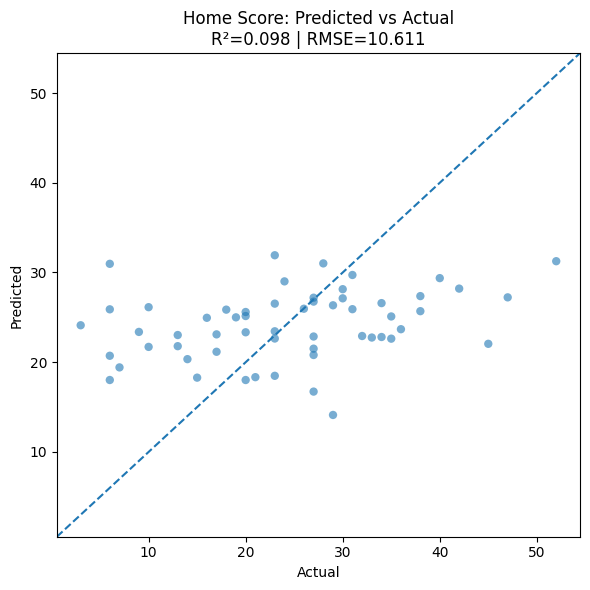

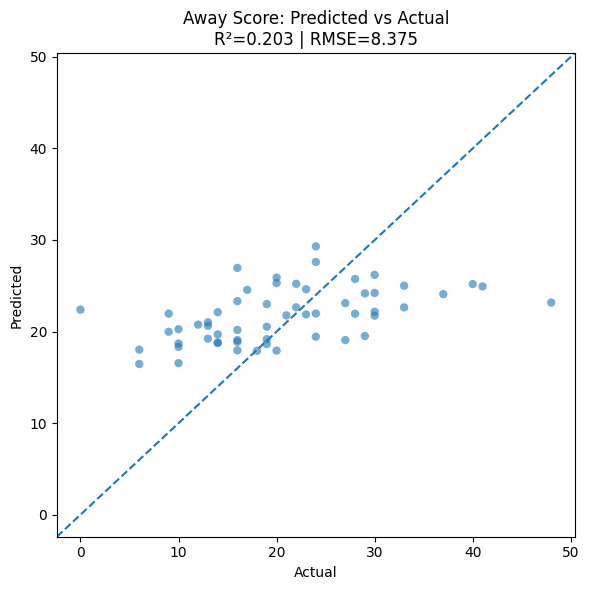

In [41]:
#Section 10: Plotting Predicted vs Actual Scores
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error

def plot_pred_vs_actual(y_true, y_pred, title):
    # axis limits
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    pad = 0.05 * (hi - lo) if hi > lo else 1.0
    lo, hi = lo - pad, hi + pad

    r2  = r2_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="none")
    plt.plot([lo, hi], [lo, hi], linestyle="--")  # 45° reference
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{title}\nR²={r2:.3f} | RMSE={rmse:.3f}")
    plt.xlim(lo, hi); plt.ylim(lo, hi)
    plt.tight_layout()
    plt.savefig(f'images/{title.replace(" ", "_").lower()}.png')  # Save the plot as an image
    plt.show()

# Home score
plot_pred_vs_actual(
    y_true=y_test["home_score"].values,
    y_pred=y_pred_ridge[:, 0],
    title="Home Score: Predicted vs Actual"
)

# Away score
plot_pred_vs_actual(
    y_true=y_test["away_score"].values,
    y_pred=y_pred_ridge[:, 1],
    title="Away Score: Predicted vs Actual"
)

In this plot points underneath the line indicate an underprediction in points whereas points above the line are overpredicted. 

Residual Plot

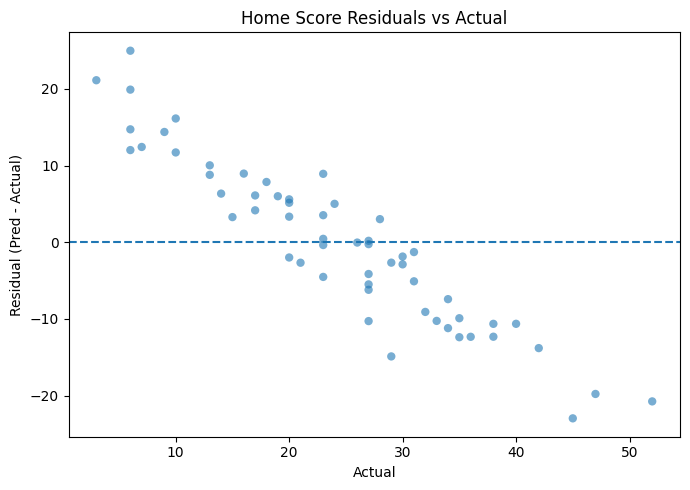

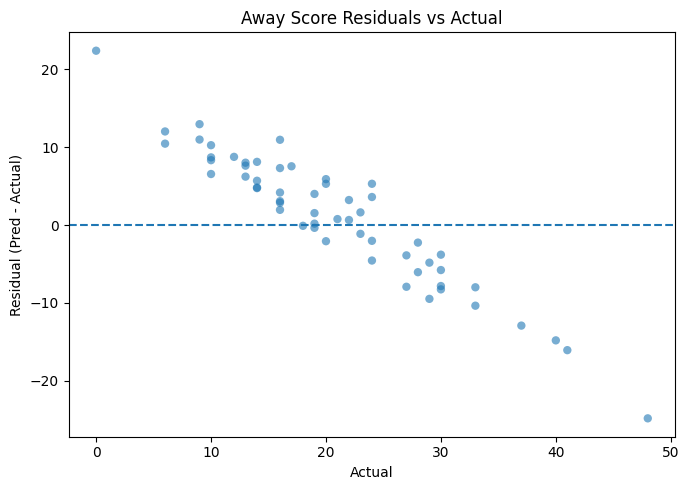

In [42]:
# Section 12: Residual plot (errors vs. true)
import matplotlib.pyplot as plt
import numpy as np

def plot_residuals_vs_true(y_true, y_pred, title):
    residuals = y_pred - y_true
    plt.figure(figsize=(7,5))
    plt.scatter(y_true, residuals, alpha=0.6, edgecolor="none")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("Actual")
    plt.ylabel("Residual (Pred - Actual)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Home residuals
plot_residuals_vs_true(
    y_true=y_test["home_score"].values,
    y_pred=y_pred_ridge[:, 0],
    title="Home Score Residuals vs Actual"
)

# Away residuals
plot_residuals_vs_true(
    y_true=y_test["away_score"].values,
    y_pred=y_pred_ridge[:, 1],
    title="Away Score Residuals vs Actual"
)

Average residual by team

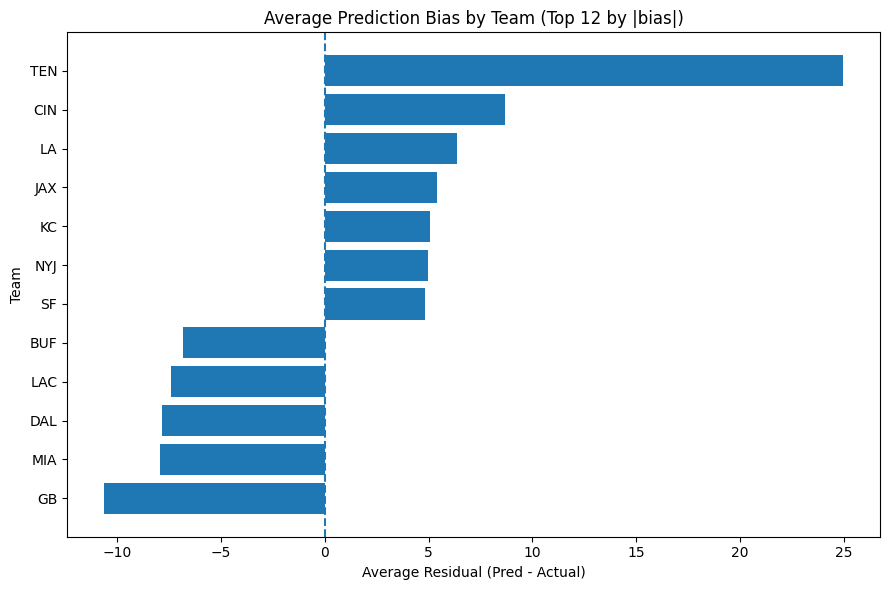

In [43]:
#Section 13: Average residual by team (bar chart) ====
# Residuals
home_resid = y_pred_ridge[:, 0] - y_test["home_score"].values
away_resid = y_pred_ridge[:, 1] - y_test["away_score"].values

# Map test indices back to teams using game_id as the key
test_game_ids = final_df.loc[X_test.index, "game_id"].values
home_teams_test = games_df.set_index("game_id").loc[test_game_ids, "home_team"].values
away_teams_test = games_df.set_index("game_id").loc[test_game_ids, "away_team"].values

import pandas as pd
res_team = pd.DataFrame({
    "team": np.concatenate([home_teams_test, away_teams_test]),
    "residual": np.concatenate([home_resid, away_resid]),
    "role": np.concatenate([np.repeat("home", len(home_resid)), np.repeat("away", len(away_resid))])
})

# Option A: overall average residual per team (combines home+away roles)
avg_by_team = res_team.groupby("team", as_index=False)["residual"].mean()
avg_by_team["abs_resid"] = avg_by_team["residual"].abs()
avg_by_team = avg_by_team.sort_values("abs_resid", ascending=False)

# Plot top 12 by absolute bias (change N as you like)
topN = 12
to_plot = avg_by_team.head(topN).sort_values("residual")

plt.figure(figsize=(9,6))
plt.barh(to_plot["team"], to_plot["residual"])
plt.axvline(0.0, linestyle="--")
plt.xlabel("Average Residual (Pred - Actual)")
plt.ylabel("Team")
plt.title(f"Average Prediction Bias by Team (Top {topN} by |bias|)")
plt.tight_layout()
plt.show()

Introduction:
	In sports, it can oftentimes be very difficult to predict the results of games given the highly variable nature of a game. One of the premier statistics that is used to quantify ‘how good’ a team is known as Defense-Adjusted Value Over Average (DVOA). In this project, I will take Total DVOA for each team in a matchup and see the relationship between Total DVOA and scores for both the home and visiting team for each matchup of the 2024 season. I seeked to answer the following questions: what is the relationship between DVOA and score, and is DVOA an effective metric in the prediction of scores.
What is DVOA?:
    DVOA is a  stat is currently owned by ftnfantasy.com. The actual calculation of this statistic is proprietary, and it is divided into four different subcategories: Offensive DVOA, Defensive DVOA, Special Teams DVOA, and Total DVOA. All these metrics are designed to measure the performance of the particular team adjusting for the quality of the defense. Total DVOA is a holistic stat that takes into account the various subcategories. Total DVOA was the only statistic of the bunch that was available for without subscription to FTN Fantasy.  I believe that this is a massive limitation to my project as the quality of the offense and defense are merged into one statistic. This statistic is given as a percentage. For example, a DVOA of 29.8% means that adjusting for the quality of the defense, a team performed 29.8% more efficiently than average.
Explanation of sections and justification of approach
Section 1:
    In my first section, I imported my NFL dataframe using the nfl_data_py tool. 
Section 2
    In section 2, I created a DVOA dictionary with DVOA stats that I was able to scrape off the internet. Ideally, I would import a dataset for this but there was nothing available  so I had to construct by hand.  From there I converted to a panda and merged with my initial dataframe to create the home_dvoa, away_dvoa, and dvoa_diff columns.
Section 3:
 In section 3, I printed dataframe info for my own visualization. 
Section 4:
    Section 4, contains the code to generate the days_rested columns for the home and away teams. To do this I first converted the gameday column to datetime. Next, I searched my dataset for the previous gamedate given the current entry. Using this, we can subtract the previous day from the current leaving us with the days of rest for each home and away team.  Nex,t I use the int type to ensure that I have support for the NaN values that will be a result of the first week of the season.
Section 5:
 In this section, I will answer my initial question of what is the relationship between DVOA and score?  First, I generated a correlation heatmap for home  & away score and home & away DVOA. We could see a moderate increase in home and away score with and increase in their respective DVOA’s. In contrast we saw a minor decrease in score for the home team with an increase in the away team’s DVOA. The same relation holds for away score and home DVOA. To further visualize this I created a scatterplot for each of our 4 relationships with a fit line. In each plot, we can see a widespread with a little bit of bias for DVOA as described with the scatterplots. This spread makes me think this will make predictions difficult given the high variability of the data. 
Section 6:
    In this section, I am creating a binary column that contains 1 if the game is outdoors and 0 if the game is indoors. To do this, I first converted all text in the column to lowercase and I then set outdoor entries as a 1 and indoor as a 0 based off of common text I found within my initial dataset. Once, I added this column I printed the head of my new column next to the original to confirm my results were correct.
Section 7: 
    In this section, I repeated the same process as section 6, except I filtered by assigning 1 for any entry containing grass, and a 0 for any entry containing ‘turf’ as there were several variations of turf called out in the initial dataset. 
Section 8:
    In this section, I am generating my training and test datasets. First, I defined my input data by dropping non-feature text, my targets, and , non-numeric columns.  Next, I used median imputation to address any potential NaN values. After this, I defined my output columns as my targets and executed an 80/20 training test split for this data. Next, the standard scalar is used to scale all of my features.
Section 9:
    In this section I am setting up and running my ridge regression model. I ended p picking this model as I found it had the best performance on the dataset used in HW4. First, I defined my alphas to test for and initialized my Ridge CV with 5-fold cross validation and fit it with my training data. Next, I print the selected best alpha and produced my prediction using my model. Next, I produced the r^2 and RMSE for home and away team values separately and together. From this value, we find an extremely small r^2 meaning that this model accounts for very little data variance and a RMSE of about 9 points. 
Section 10:
    In this section to better understand the results, I produced a plot showing a scatter plot of the home/away actual scores, vs the home/away predicted scores. If the predicted scores are close, the data would closely hug the 45-degree line that I added for visualization. When looking at my scores, I believe that this model was highly washed out by the averages as most values predicted tended to hover close to the average NFL score which typically resides in the mid 20’s. With the generated plots, we can see our model doesn’t have over or underpredicting bias, it just is unable to capture the highly variant nature of NFL games given its current information. Ideas to improve this model will be in the discussion section. 
Discussion:
    In this project, we were able to determine that there is a correlation between DVOA and score but in our current model, it was not enough to predict scores with any degree of confidence. I believe that first of all, the project was limited by the fact that I had to use total DVOA. If I had the ability to separate into offensive and defensive DVOA it would allow for this model to be specific as it currently would not know the difference between a team that has a good offense and a bad defense and a bad offense and good defense. Another limitation is that I had to use end of season data. Ideally, I would add DVOA week by week as the stat changes over the course of the season.
    
 I also think that there is potential for more data that I could add if a decent model was my end goal. For example, I could pull in quarterback metrics or provide the score from the previous week of play. I think there are many other metrics that I could use but for this project, I wanted the focus to be primarily on total DVOA. I definitely leave this project very curious what the results would be if I had access to the more dynamic DVOA datasets kept behind FTN’s paywall.


